In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**使用 CuPy 实现 GPU 加速**

In [ ]:
nvcc --version

In [ ]:
!pip install cupy-cuda12x --no-cache-dir 

##相应准备

In [1]:
import cupy as cp  # 替换 numpy 为 cupy
import numpy as np  # 仅用于最后与 CPU 的数据交互
import matplotlib.pyplot as plt
import pickle
import os
from tqdm import tqdm

In [ ]:
# 验证 CuPy 是否正确安装
try:
    print(f"CuPy 版本: {cp.__version__}")
    print(f"使用的 CUDA 设备: {cp.cuda.Device().name}")
except Exception as e:
    print(f"CuPy 初始化失败: {str(e)}")
    print("正在尝试回退到 CPU 模式...")
    cp = np  # 回退到 NumPy
    print("已回退到 CPU 模式")


In [ ]:
import cupy as cp
import numpy as np

try:
    print(f"CuPy 版本: {cp.__version__}")
    with cp.cuda.Device(0) as dev:  # 更安全的设备访问方式
        print(f"计算能力: {dev.compute_capability}")
        mem_info = cp.cuda.runtime.memGetInfo()
        print(f"可用显存: {mem_info[0]/1024**2:.2f} MB / {mem_info[1]/1024**2:.2f} MB")
    # 运行一个简单的 CuPy 计算验证
    x = cp.arange(10)
    print(f"CuPy 计算测试: {x.sum()}")
except Exception as e:
    print(f"GPU 初始化失败: {str(e)}")
    print("回退到 CPU 模式...")
    cp = np

In [ ]:
# 示例：大规模矩阵乘法（GPU 加速）
a = cp.random.rand(10000, 10000)
b = cp.random.rand(10000, 10000)
c = a @ b  # 在 GPU 上执行

# ## 1. 数据准备
# 
# 加载 CIFAR-10 数据集并进行预处理

In [2]:
def load_cifar10(data_dir):
    def unpickle(file):
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict

    # 加载训练集
    train_data = []
    train_labels = []
    for i in range(1, 6):
        file = os.path.join(data_dir, f'data_batch_{i}')
        batch = unpickle(file)
        train_data.append(batch[b'data'])
        train_labels.extend(batch[b'labels'])
    train_data = cp.array(np.concatenate(train_data))  # 转换为 CuPy 数组
    train_labels = cp.array(np.array(train_labels))

    # 加载测试集
    test_file = os.path.join(data_dir, 'test_batch')
    test_batch = unpickle(test_file)
    test_data = cp.array(test_batch[b'data'])  # 直接转换为 CuPy 数组
    test_labels = cp.array(np.array(test_batch[b'labels']))

    return train_data, train_labels, test_data, test_labels

# %% [code]
# 加载数据到 GPU
train_data, train_labels, test_data, test_labels = load_cifar10('/kaggle/input/cifar-10-batches-py/cifar-10-batches-py')

# 划分验证集 (数据已在 GPU 上)
num_val = 1000
X_val, y_val = train_data[:num_val], train_labels[:num_val]
X_train, y_train = train_data[num_val:], train_labels[num_val:]

# 数据预处理 (在 GPU 上执行)
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
test_data = test_data.astype('float32') / 255.0

print(f"训练集: {X_train.shape}, {y_train.shape}")
print(f"验证集: {X_val.shape}, {y_val.shape}")
print(f"测试集: {test_data.shape}, {test_labels.shape}")


训练集: (49000, 3072), (49000,)
验证集: (1000, 3072), (1000,)
测试集: (10000, 3072), (10000,)


# ## 2. 模型实现
# 
# 实现一个三层神经网络 (输入层-隐藏层-输出层)

In [3]:
class ThreeLayerNeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, activation='relu'):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.activation = activation

        # He初始化 (直接在 GPU 上创建数组)
        self.params = {
            'W1': cp.random.randn(input_size, hidden_size) * cp.sqrt(2 / input_size),
            'b1': cp.zeros(hidden_size),
            'W2': cp.random.randn(hidden_size, output_size) * cp.sqrt(2 / hidden_size),
            'b2': cp.zeros(output_size)
        }
        self.cache = {}

    def forward(self, X):
        self.cache = {'X': X}
        
        # 第一层 (全部使用 CuPy 函数)
        Z1 = X.dot(self.params['W1']) + self.params['b1']
        if self.activation == 'relu':
            A1 = cp.maximum(0, Z1)
        elif self.activation == 'sigmoid':
            A1 = 1 / (1 + cp.exp(-Z1))
        self.cache.update({'Z1': Z1, 'A1': A1})

        # 第二层
        Z2 = A1.dot(self.params['W2']) + self.params['b2']
        exp_scores = cp.exp(Z2 - cp.max(Z2, axis=1, keepdims=True))
        A2 = exp_scores / cp.sum(exp_scores, axis=1, keepdims=True)
        self.cache.update({'Z2': Z2, 'A2': A2})
        return A2

    def backward(self, X, y, reg_lambda=0.0):
        m = X.shape[0]
        A1, A2 = self.cache['A1'], self.cache['A2']
        W1, W2 = self.params['W1'], self.params['W2']

        # 输出层梯度 (全部使用 CuPy 操作)
        dZ2 = A2 - y
        grads = {
            'W2': A1.T.dot(dZ2)/m + reg_lambda*W2,
            'b2': cp.sum(dZ2, axis=0)/m
        }

        # 隐藏层梯度
        dA1 = dZ2.dot(W2.T)
        if self.activation == 'relu':
            dZ1 = dA1 * (A1 > 0)
        elif self.activation == 'sigmoid':
            dZ1 = dA1 * A1 * (1 - A1)
        
        grads.update({
            'W1': X.T.dot(dZ1)/m + reg_lambda*W1,
            'b1': cp.sum(dZ1, axis=0)/m
        })
        return grads

    def compute_loss(self, X, y, reg_lambda=0.0):
        m = y.shape[0]
        A2 = self.forward(X)
        correct_logprobs = -cp.log(A2[cp.arange(m), y.argmax(axis=1)] + 1e-8)
        data_loss = cp.sum(correct_logprobs)/m
        reg_loss = 0.5*reg_lambda*(cp.sum(self.params['W1']**2) + cp.sum(self.params['W2']**2))
        return data_loss + reg_loss


# ## 3. 训练过程
# 
# 实现 SGD 优化器、学习率下降、早停等训练逻辑


In [4]:
def random_flip(X, p=0.5):
    """GPU 加速的随机水平翻转"""
    if len(X.shape) == 2:
        X_reshaped = X.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
        flip_mask = cp.random.rand(len(X_reshaped)) < p
        X_reshaped[flip_mask] = X_reshaped[flip_mask, :, ::-1, :]
        return X_reshaped.transpose(0, 3, 1, 2).reshape(-1, 3072)
    else:
        flip_mask = cp.random.rand(len(X)) < p
        X[flip_mask] = X[flip_mask, :, ::-1, :]
        return X
def random_crop(X, pad=4):
    """GPU 加速的随机裁剪（支持批处理）"""
    # 输入形状检查（兼容展平数据或原始形状）
    if len(X.shape) == 2:
        X_reshaped = X.reshape(-1, 3, 32, 32)  # (N, 3072) -> (N, 3, 32, 32)
    else:
        X_reshaped = X  # 假设已经是 (N, 3, 32, 32)
    
    # 反射填充（CuPy 实现）
    padded = cp.pad(X_reshaped, 
                   ((0, 0), (0, 0), (pad, pad), (pad, pad)), 
                   mode='reflect')
    
    # 随机裁剪位置（向量化生成）
    N = X_reshaped.shape[0]
    h, w = 32, 32  # CIFAR-10 原始尺寸
    starts_h = cp.random.randint(0, 2 * pad, size=N)
    starts_w = cp.random.randint(0, 2 * pad, size=N)
    
    # 批量裁剪（避免循环）
    crops = cp.zeros_like(X_reshaped)
    for i in range(N):
        crops[i] = padded[i, :, 
                         starts_h[i]:starts_h[i] + h, 
                         starts_w[i]:starts_w[i] + w]
    
    return crops.reshape(-1, 3072)  # 展平回 (N, 3072)

def train(model, X_train, y_train, X_val, y_val, 
          learning_rate=1e-3, lr_decay=0.95, 
          reg=1e-5, epochs=100, batch_size=256,
          early_stop=5, verbose=True):
    
    # 数据预处理 (已在 GPU 上)
    y_train_onehot = cp.eye(model.output_size)[y_train]
    y_val_onehot = cp.eye(model.output_size)[y_val]

    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    best_val_acc = 0
    best_params = None
    no_improve = 0
    
    for epoch in tqdm(range(epochs), desc="Training"):
        if epoch % 10 == 0 and epoch > 0:
            learning_rate *= lr_decay
        
        indices = cp.random.permutation(len(X_train))
        for i in range(0, len(X_train), batch_size):
            batch_idx = indices[i:i+batch_size]
            X_batch, y_batch = X_train[batch_idx], y_train_onehot[batch_idx]
            X_batch = random_crop(X_batch)      # 随机裁剪
            X_batch = random_flip(X_batch)      # 随机翻转
            
            
            
            model.forward(X_batch)
            grads = model.backward(X_batch, y_batch, reg)
            
            for param in model.params:
                model.params[param] -= learning_rate * grads[param]
        
        # 评估 (注意将结果转回 CPU 用于记录)
        train_loss = model.compute_loss(X_train, y_train_onehot, reg)
        train_pred = model.forward(X_train).argmax(axis=1)
        train_acc = cp.mean(train_pred == y_train)
        
        val_loss = model.compute_loss(X_val, y_val_onehot, reg)
        val_pred = model.forward(X_val).argmax(axis=1)
        val_acc = cp.mean(val_pred == y_val)
        
        # 记录历史数据 (转换为 float 类型)
        history['train_loss'].append(float(train_loss))
        history['train_acc'].append(float(train_acc))
        history['val_loss'].append(float(val_loss))
        history['val_acc'].append(float(val_acc))
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_params = {k: v.copy() for k, v in model.params.items()}
            no_improve = 0
        else:
            no_improve += 1
            
        if no_improve >= early_stop:
            if verbose:
                print(f"Early stopping at epoch {epoch}")
            break
            
        if verbose and epoch % 5 == 0:
            print(f"Epoch {epoch}: train_loss={float(train_loss):.4f}, val_acc={float(val_acc):.4f}, lr={learning_rate:.2e}")
    
    model.params = best_params
    
    # 可视化
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.title('Loss Curve')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['val_acc'], label='Validation')
    plt.title('Accuracy Curve')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_curves.png')
    plt.show()
    
    return model, history

In [ ]:
import matplotlib.pyplot as plt
import cupy as cp

def visualize_augmentation(X, num_samples=5):
    """可视化数据增强效果"""
    X = X[:num_samples]
    X_aug = random_flip(random_crop(X))
    
    plt.figure(figsize=(15, 4))
    for i in range(num_samples):
        # 原始图像
        plt.subplot(2, num_samples, i+1)
        img = X[i].reshape(3, 32, 32).transpose(1, 2, 0).get()
        plt.imshow(img)
        plt.title("Original")
        plt.axis('off')
        
        # 增强后图像
        plt.subplot(2, num_samples, num_samples+i+1)
        img_aug = X_aug[i].reshape(3, 32, 32).transpose(1, 2, 0).get()
        plt.imshow(img_aug)
        plt.title("Augmented")
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('data_augmentation.png')
    plt.show()

# 使用示例
visualize_augmentation(X_train[:5])  # 可视化前5个样本

# ## 4. 超参数搜索
# 
# 搜索最佳的学习率、隐藏层大小和正则化强度


In [5]:
def hyperparameter_search(X_train, y_train, X_val, y_val):
    learning_rates = [1e-1, 1e-2, 1e-3]
    hidden_sizes = [128, 200, 520]
    reg_strengths = [1e-4, 1e-3, 1e-2]

    best_val = -1
    best_hyperparams = {}

    # 确保数据已经在GPU上
    if not isinstance(X_train, cp.ndarray):
        X_train = cp.array(X_train)
    if not isinstance(y_train, cp.ndarray):
        y_train = cp.array(y_train)
    if not isinstance(X_val, cp.ndarray):
        X_val = cp.array(X_val)
    if not isinstance(y_val, cp.ndarray):
        y_val = cp.array(y_val)

    for lr in learning_rates:
        for hs in hidden_sizes:
            for reg in reg_strengths:
                print(f"\nTesting lr={lr}, hidden_size={hs}, reg={reg}")
                
                # 初始化模型 - 参数已在类内部使用CuPy初始化
                model = ThreeLayerNeuralNetwork(
                    input_size=3072, 
                    hidden_size=hs, 
                    output_size=10,
                    activation='relu'
                )
                
                # 训练模型
                trained_model, history = train(
                    model, 
                    X_train, y_train, 
                    X_val, y_val,
                    learning_rate=lr,
                    reg=reg,
                    epochs=50,  # 为了加快搜索，使用较少的epoch
                    verbose=False
                )
                
                # 计算验证准确率
                val_pred = trained_model.forward(X_val).argmax(axis=1)
                val_acc = float(cp.mean(val_pred == y_val))
                print(f"Validation accuracy: {val_acc:.4f}")

                if val_acc > best_val:
                    best_val = val_acc
                    best_hyperparams = {
                        'learning_rate': lr,
                        'hidden_size': hs,
                        'reg': reg
                    }
                    print("New best!")

    print(f'\nBest validation accuracy: {best_val:.4f}')
    print(f'Best hyperparameters: {best_hyperparams}')
    return best_hyperparams


Testing lr=0.1, hidden_size=128, reg=0.0001


Training:  46%|████▌     | 23/50 [04:29<05:16, 11.72s/it]


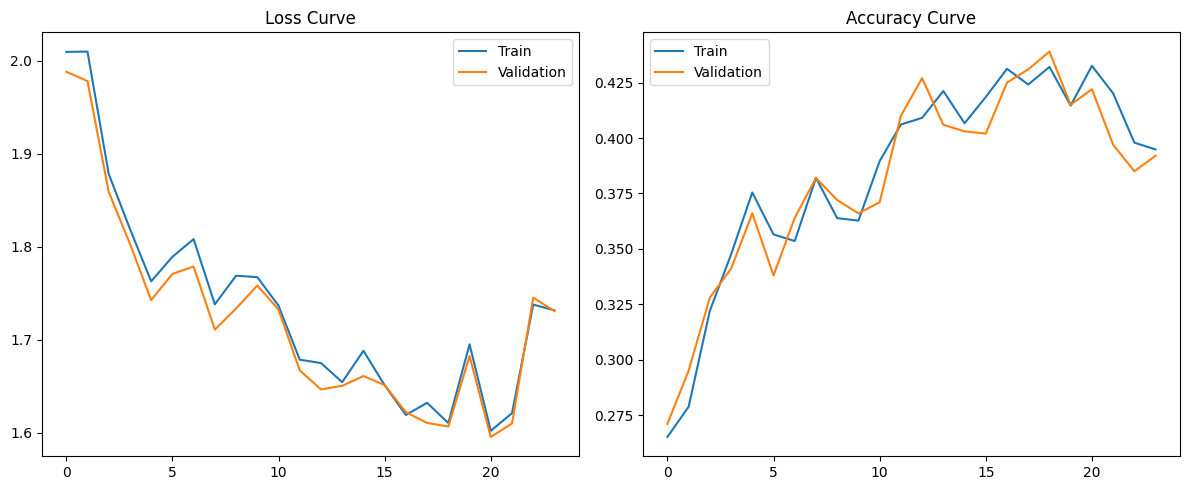

Validation accuracy: 0.4390
New best!

Testing lr=0.1, hidden_size=128, reg=0.001


Training:  22%|██▏       | 11/50 [02:07<07:33, 11.64s/it]


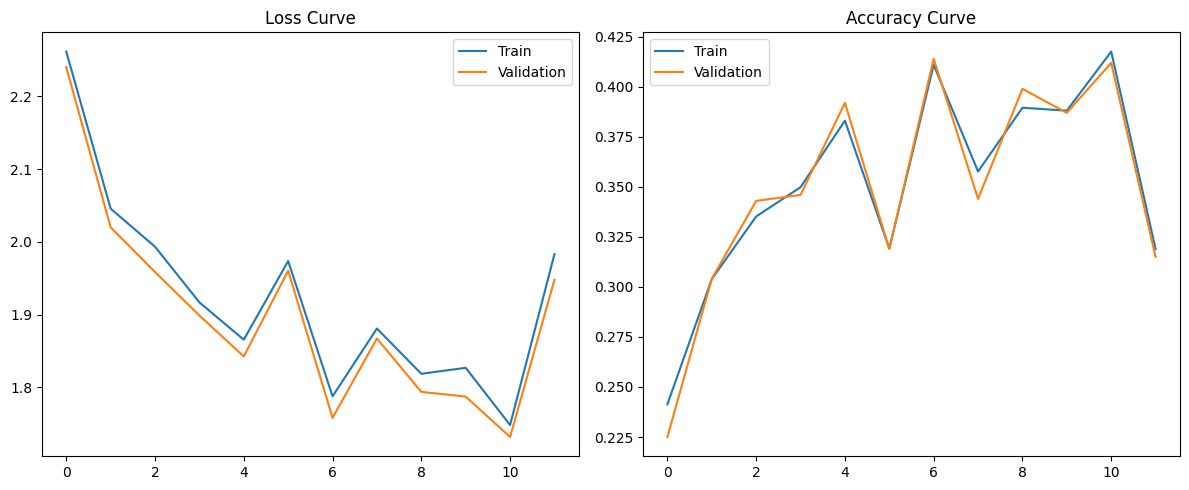

Validation accuracy: 0.4140

Testing lr=0.1, hidden_size=128, reg=0.01


Training:  18%|█▊        | 9/50 [01:47<08:09, 11.95s/it]


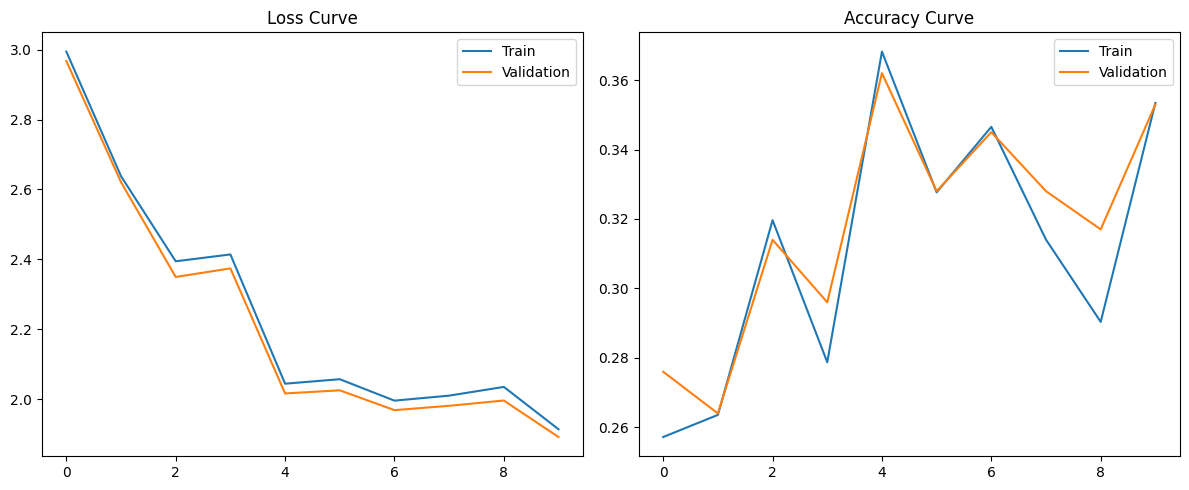

Validation accuracy: 0.3620

Testing lr=0.1, hidden_size=200, reg=0.0001


Training:  52%|█████▏    | 26/50 [05:23<04:58, 12.44s/it]


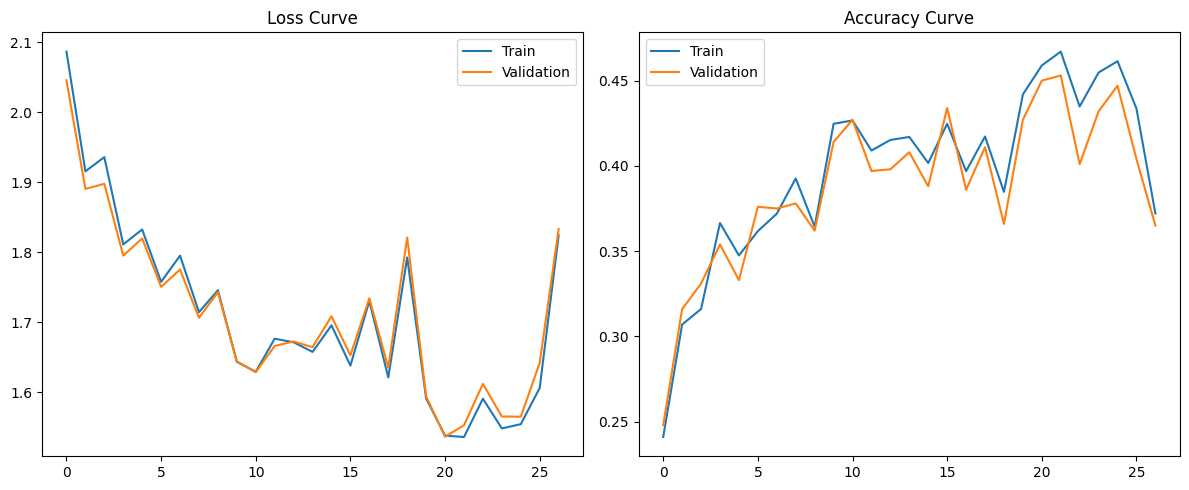

Validation accuracy: 0.4530
New best!

Testing lr=0.1, hidden_size=200, reg=0.001


Training:  36%|███▌      | 18/50 [03:47<06:45, 12.66s/it]


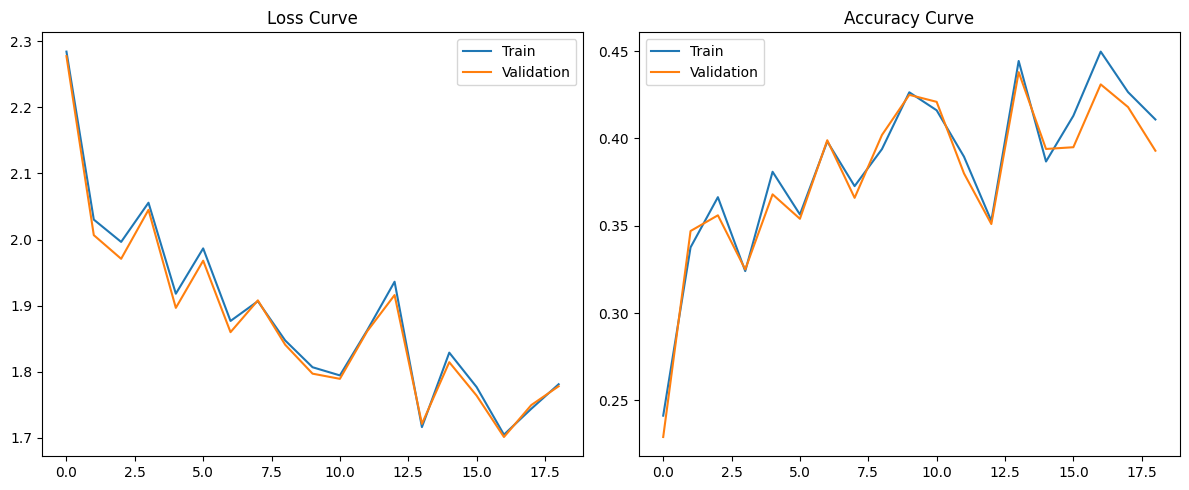

Validation accuracy: 0.4380

Testing lr=0.1, hidden_size=200, reg=0.01


Training:  60%|██████    | 30/50 [06:11<04:07, 12.39s/it]


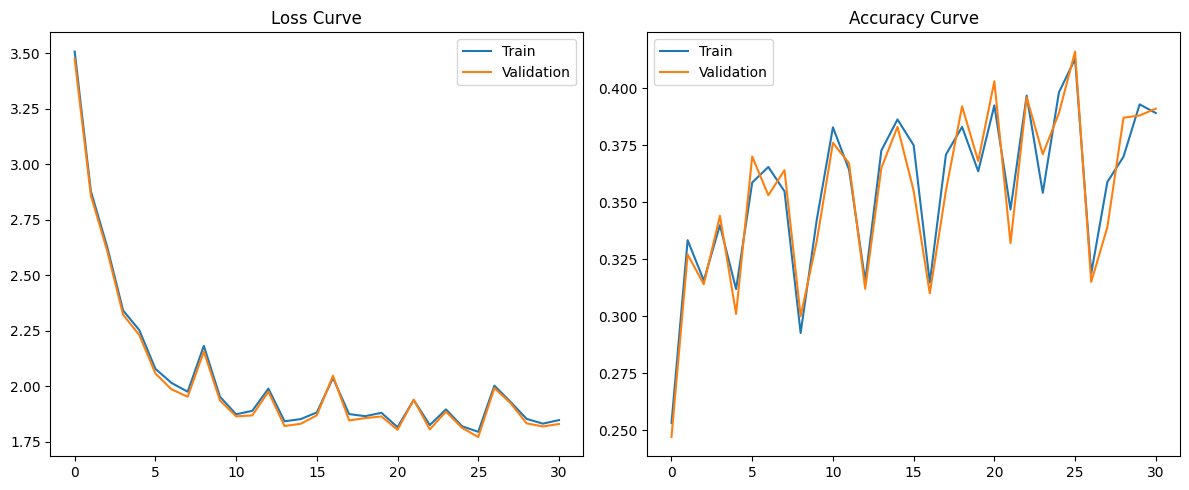

Validation accuracy: 0.4160

Testing lr=0.1, hidden_size=520, reg=0.0001


Training:  52%|█████▏    | 26/50 [06:21<05:51, 14.66s/it]


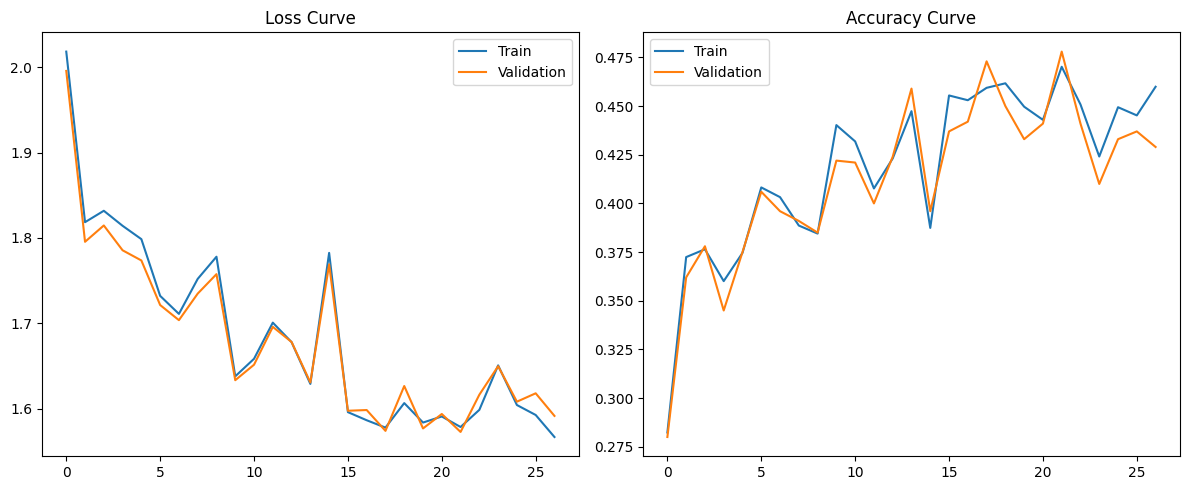

Validation accuracy: 0.4780
New best!

Testing lr=0.1, hidden_size=520, reg=0.001


Training:  22%|██▏       | 11/50 [02:49<10:02, 15.45s/it]


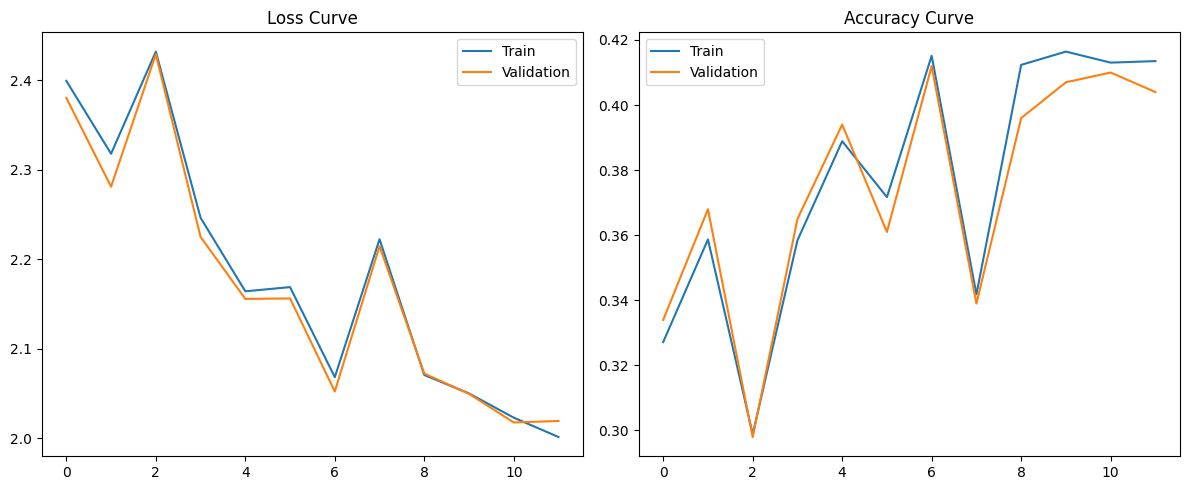

Validation accuracy: 0.4120

Testing lr=0.1, hidden_size=520, reg=0.01


Training:  30%|███       | 15/50 [03:46<08:49, 15.13s/it]


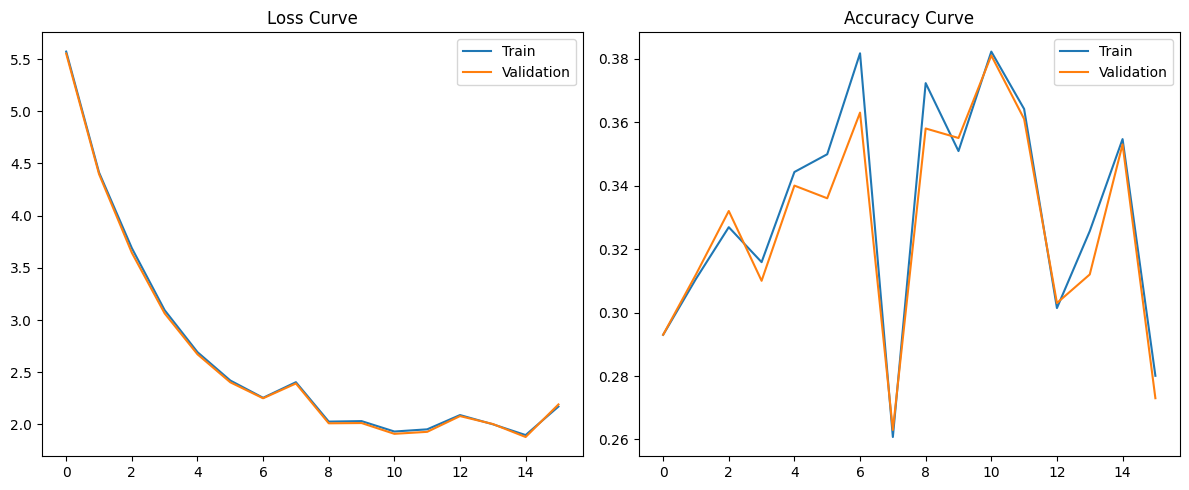

Validation accuracy: 0.3810

Testing lr=0.01, hidden_size=128, reg=0.0001


Training:  22%|██▏       | 11/50 [02:10<07:41, 11.84s/it]


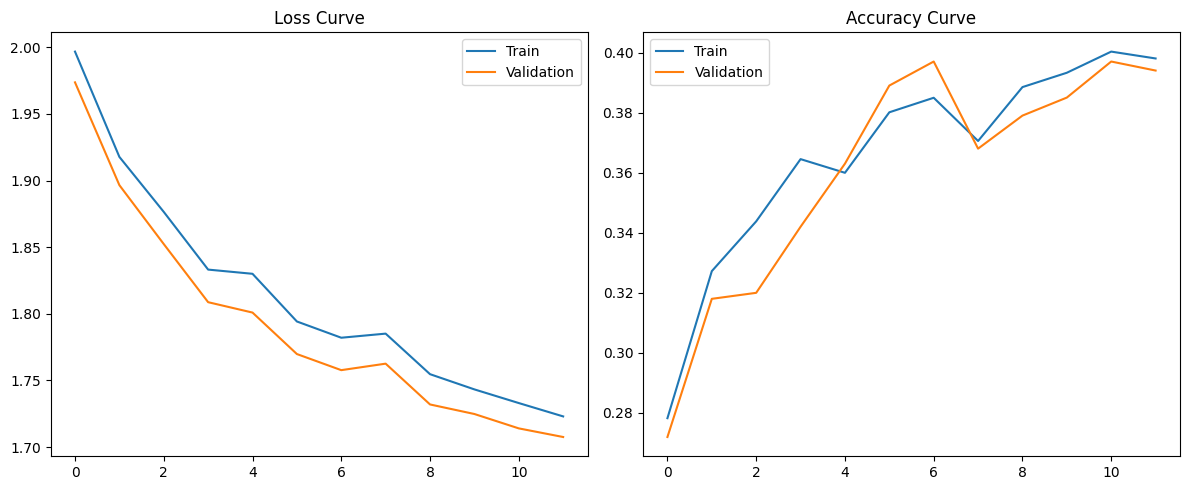

Validation accuracy: 0.3970

Testing lr=0.01, hidden_size=128, reg=0.001


Training:  40%|████      | 20/50 [03:46<05:39, 11.31s/it]


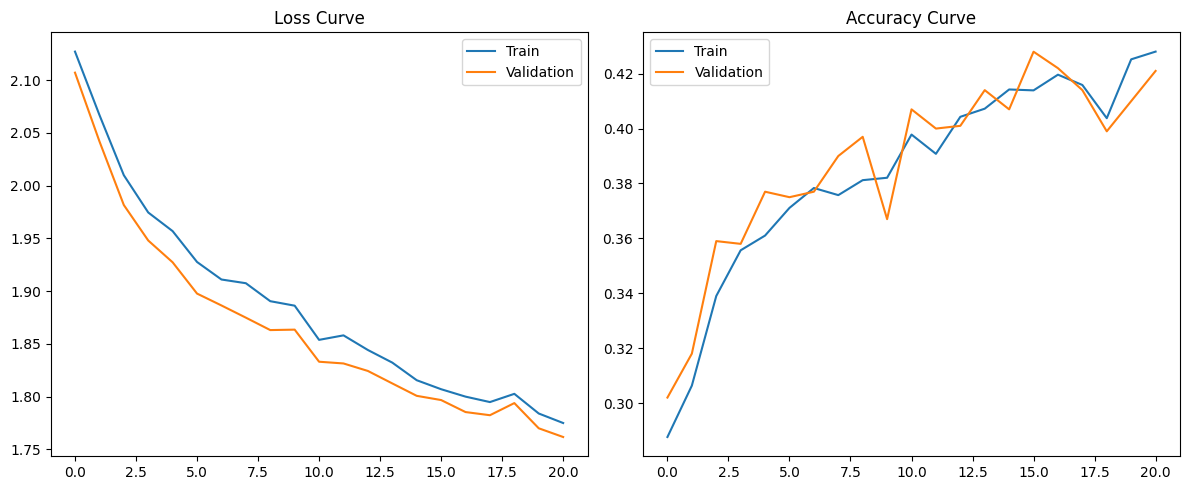

Validation accuracy: 0.4280

Testing lr=0.01, hidden_size=128, reg=0.01


Training:  62%|██████▏   | 31/50 [05:44<03:30, 11.10s/it]


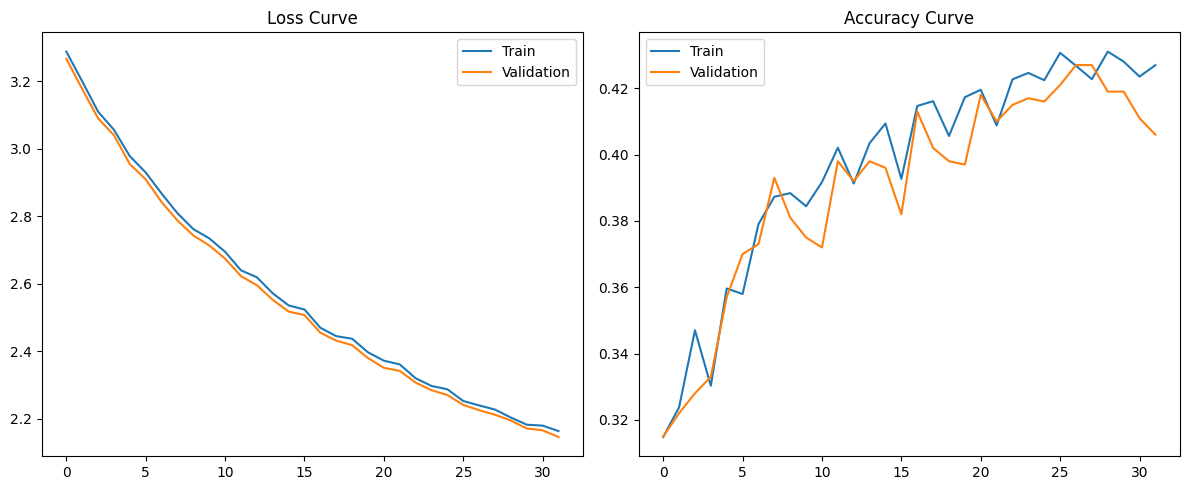

Validation accuracy: 0.4270

Testing lr=0.01, hidden_size=200, reg=0.0001


Training:  66%|██████▌   | 33/50 [06:49<03:30, 12.40s/it]


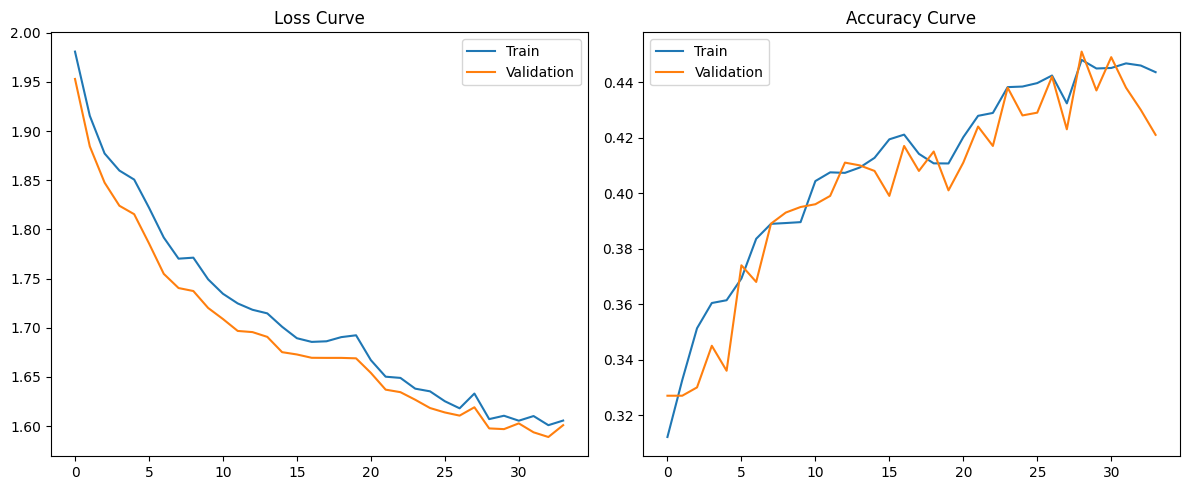

Validation accuracy: 0.4510

Testing lr=0.01, hidden_size=200, reg=0.001


Training:  92%|█████████▏| 46/50 [09:24<00:49, 12.27s/it]


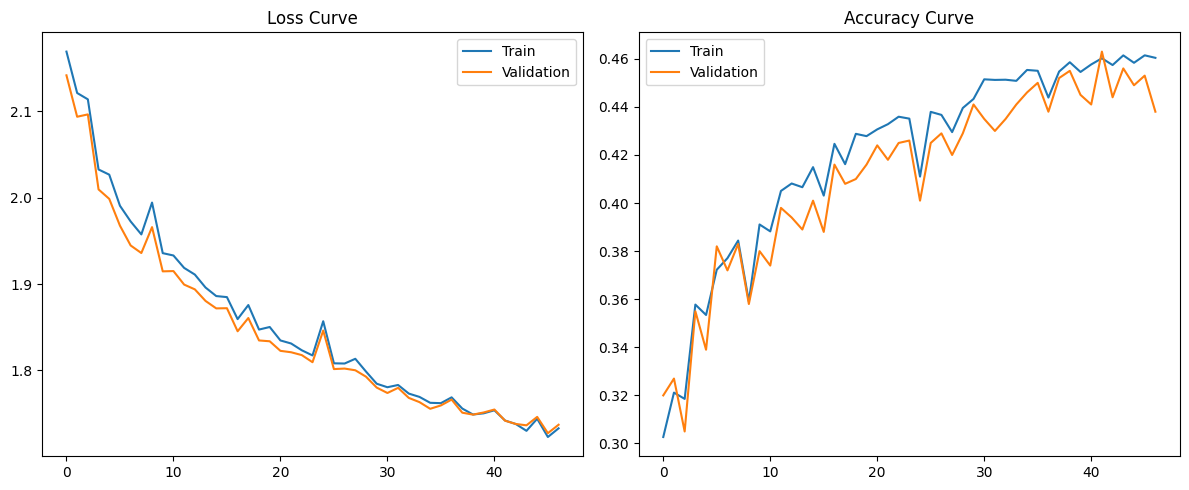

Validation accuracy: 0.4630

Testing lr=0.01, hidden_size=200, reg=0.01


Training:  36%|███▌      | 18/50 [03:49<06:47, 12.73s/it]


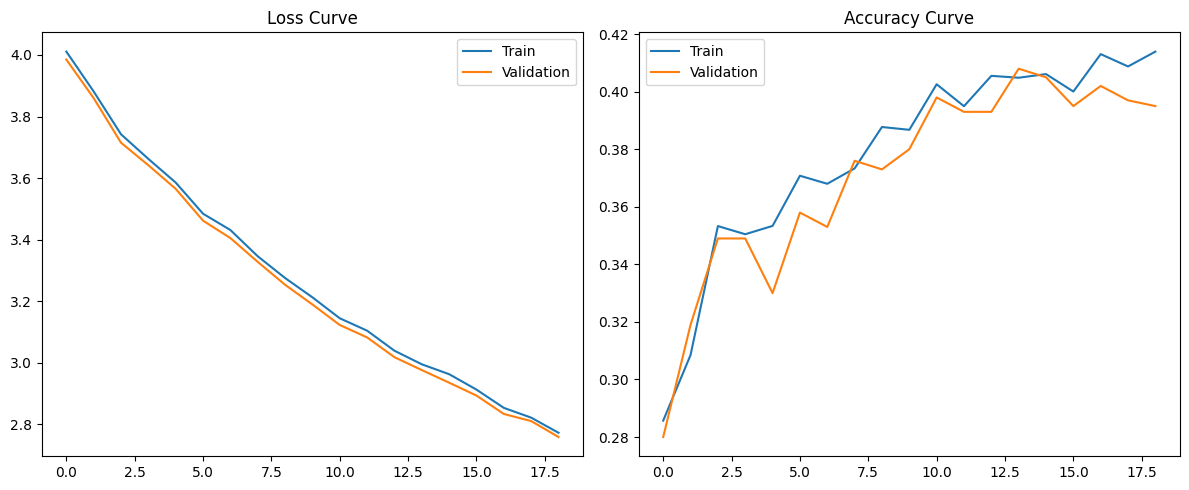

Validation accuracy: 0.4080

Testing lr=0.01, hidden_size=520, reg=0.0001


Training:  74%|███████▍  | 37/50 [08:57<03:08, 14.53s/it]


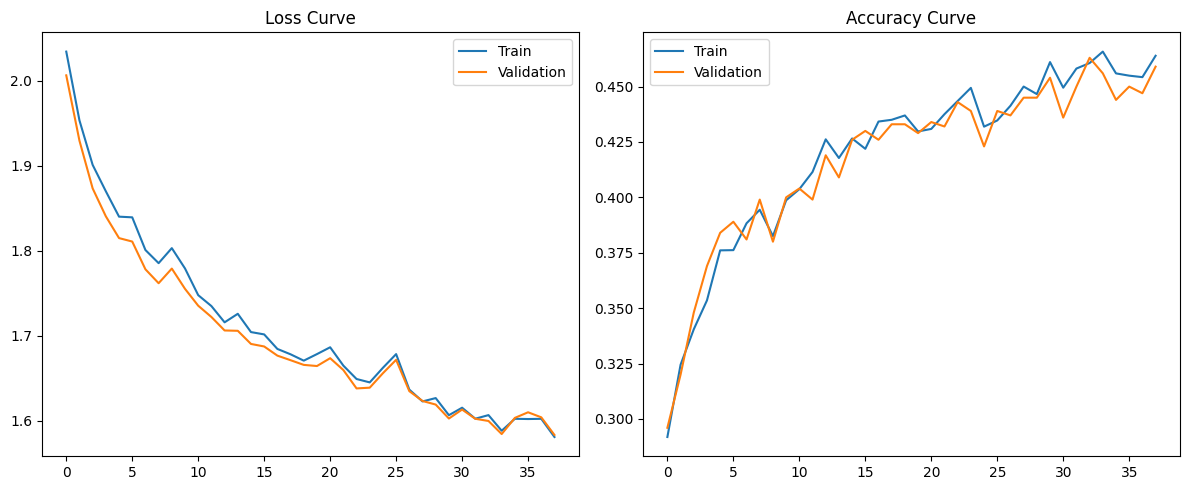

Validation accuracy: 0.4630

Testing lr=0.01, hidden_size=520, reg=0.001


Training:  14%|█▍        | 7/50 [01:52<11:33, 16.12s/it]


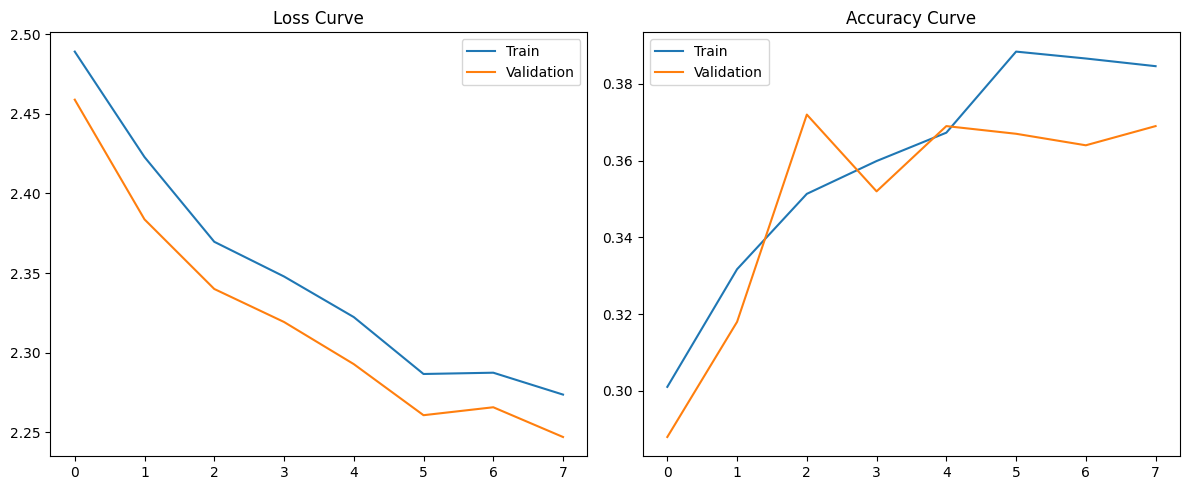

Validation accuracy: 0.3720

Testing lr=0.01, hidden_size=520, reg=0.01


Training:  40%|████      | 20/50 [04:55<07:23, 14.77s/it]


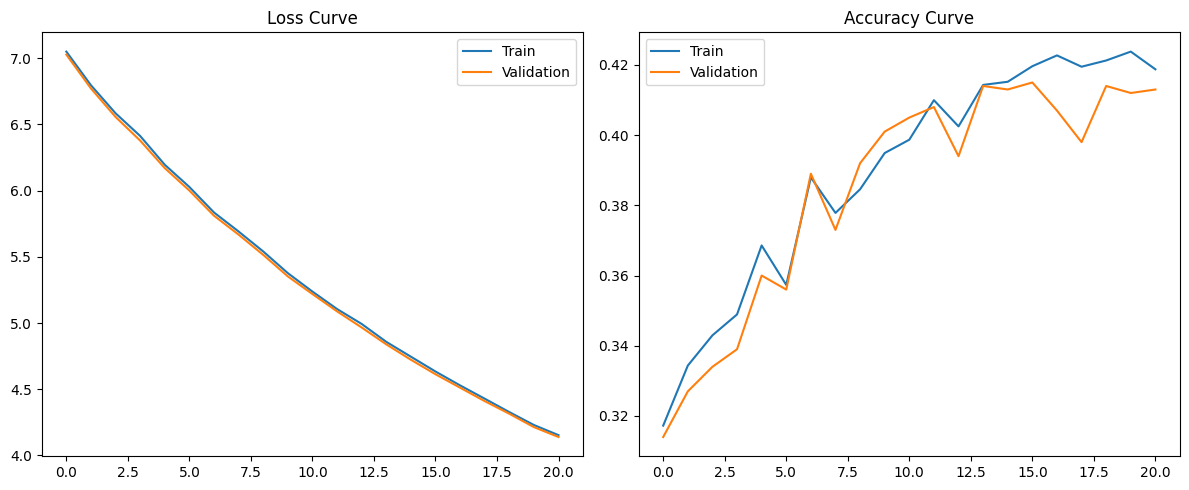

Validation accuracy: 0.4150

Testing lr=0.001, hidden_size=128, reg=0.0001


Training:  88%|████████▊ | 44/50 [08:05<01:06, 11.04s/it]


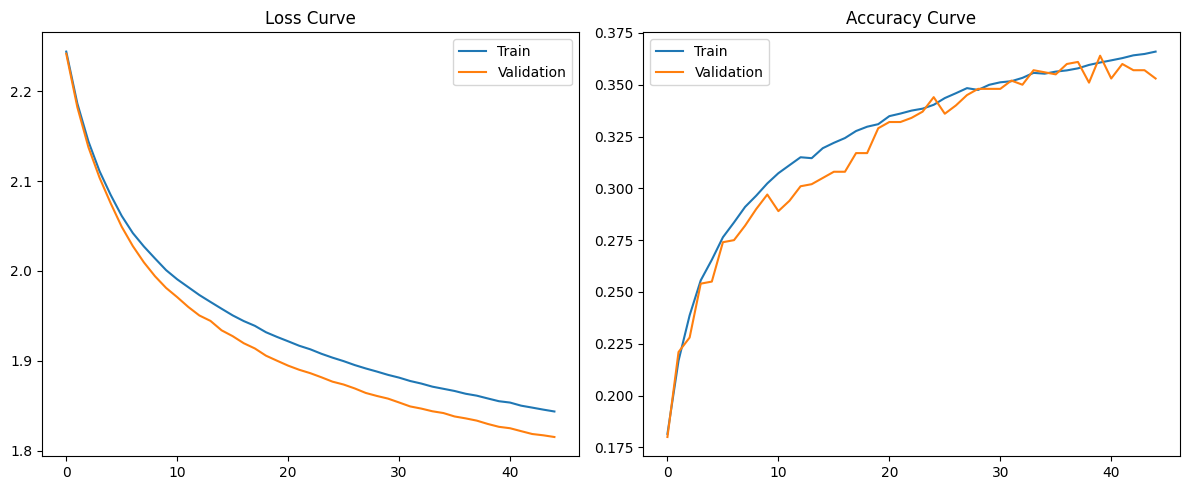

Validation accuracy: 0.3640

Testing lr=0.001, hidden_size=128, reg=0.001


Training:  68%|██████▊   | 34/50 [06:18<02:58, 11.13s/it]


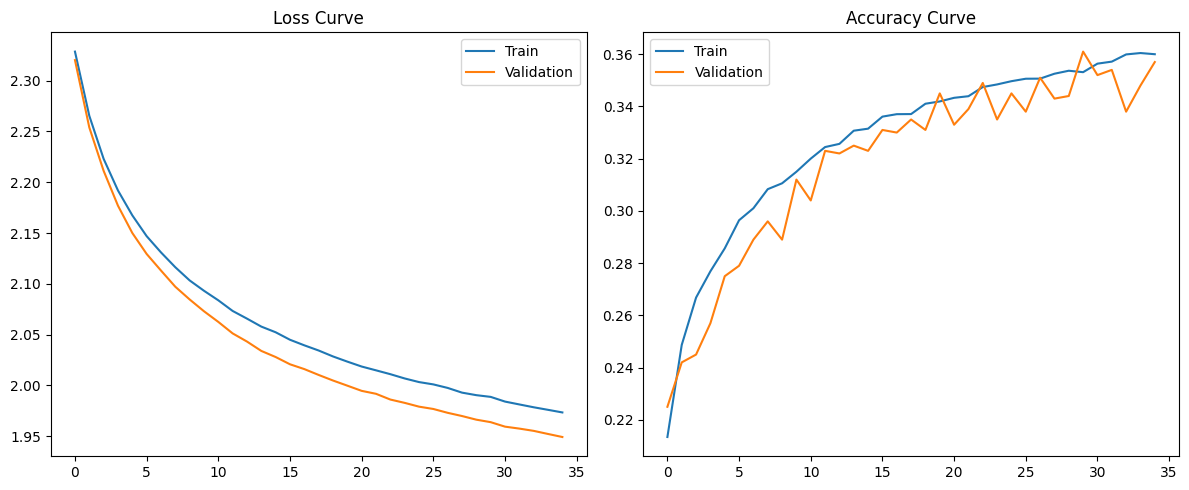

Validation accuracy: 0.3610

Testing lr=0.001, hidden_size=128, reg=0.01


Training:  54%|█████▍    | 27/50 [05:02<04:17, 11.20s/it]


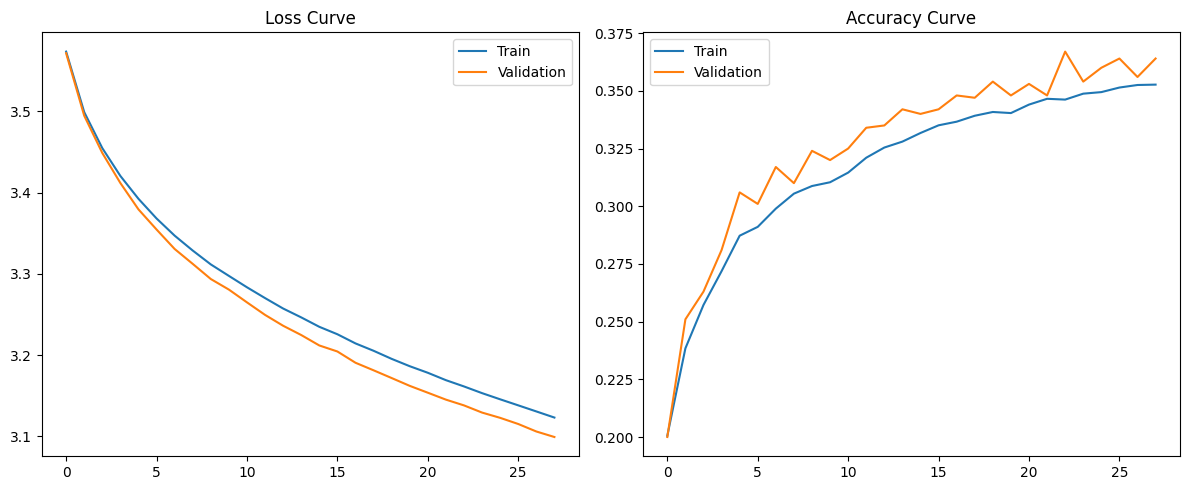

Validation accuracy: 0.3670

Testing lr=0.001, hidden_size=200, reg=0.0001


Training:  60%|██████    | 30/50 [06:12<04:08, 12.42s/it]


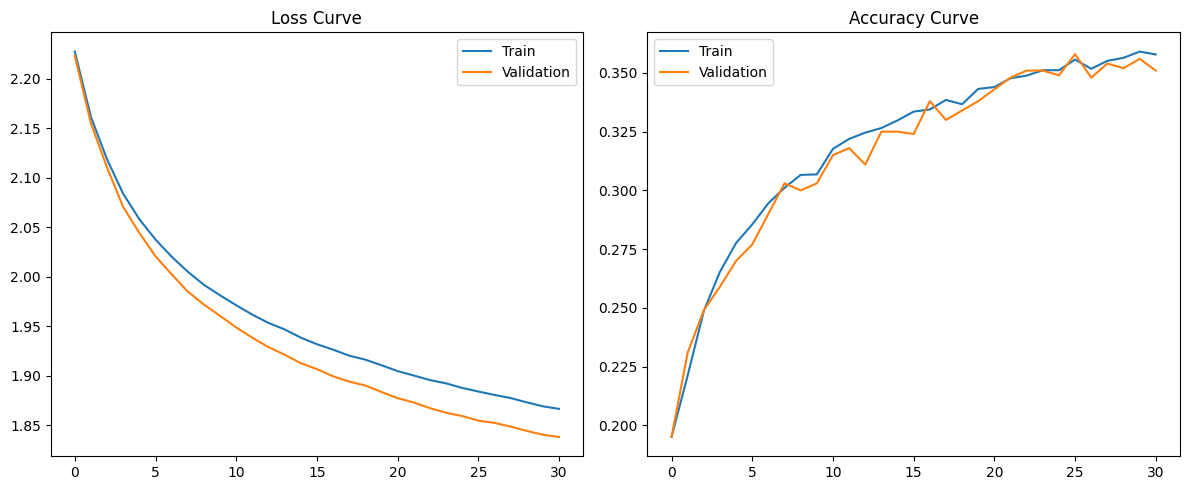

Validation accuracy: 0.3580

Testing lr=0.001, hidden_size=200, reg=0.001


Training:  76%|███████▌  | 38/50 [07:48<02:27, 12.33s/it]


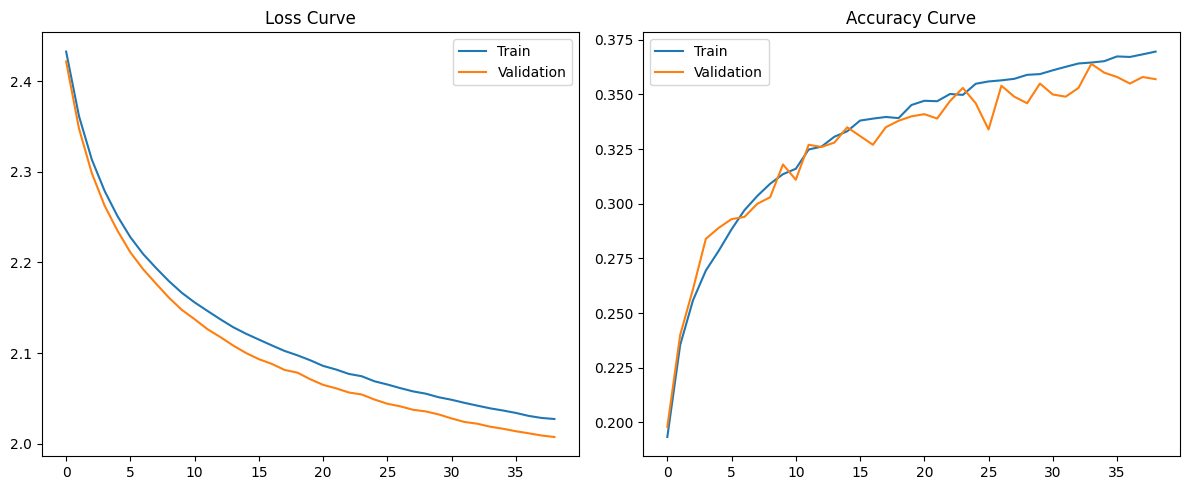

Validation accuracy: 0.3640

Testing lr=0.001, hidden_size=200, reg=0.01


Training:  76%|███████▌  | 38/50 [07:47<02:27, 12.31s/it]


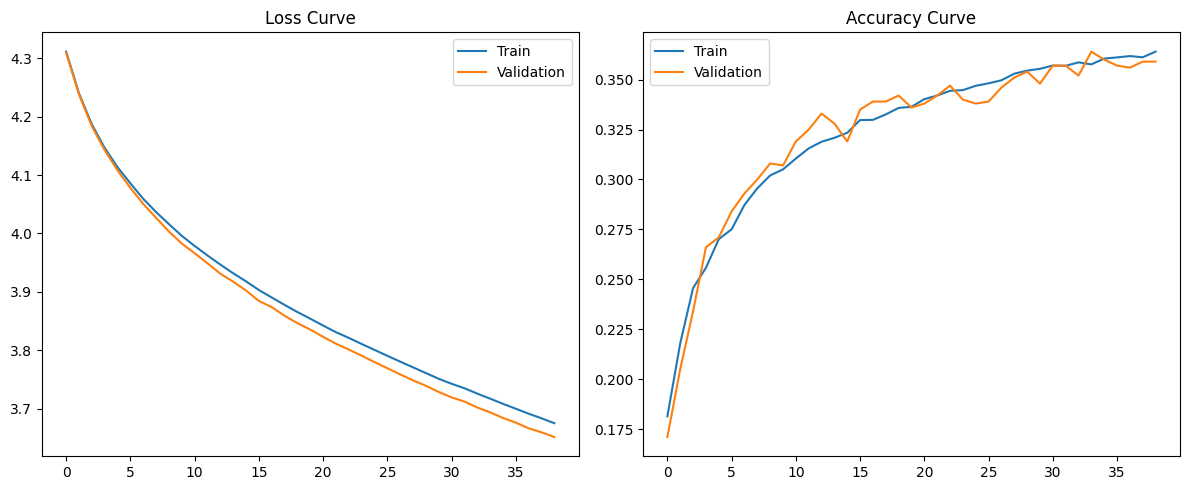

Validation accuracy: 0.3640

Testing lr=0.001, hidden_size=520, reg=0.0001


Training:  64%|██████▍   | 32/50 [07:45<04:21, 14.54s/it]


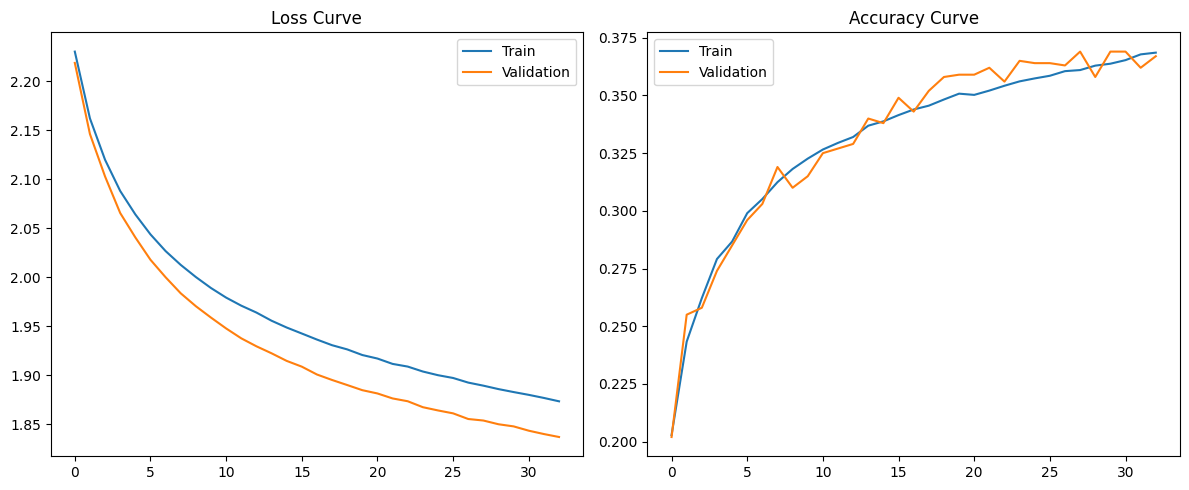

Validation accuracy: 0.3690

Testing lr=0.001, hidden_size=520, reg=0.001


Training:  54%|█████▍    | 27/50 [06:34<05:36, 14.61s/it]


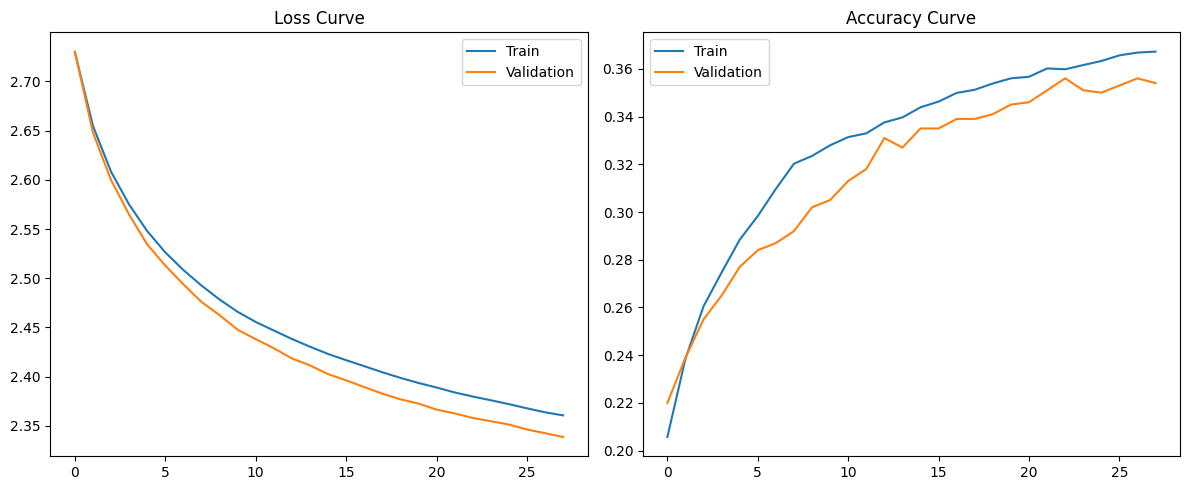

Validation accuracy: 0.3560

Testing lr=0.001, hidden_size=520, reg=0.01


Training:  70%|███████   | 35/50 [08:28<03:37, 14.52s/it]


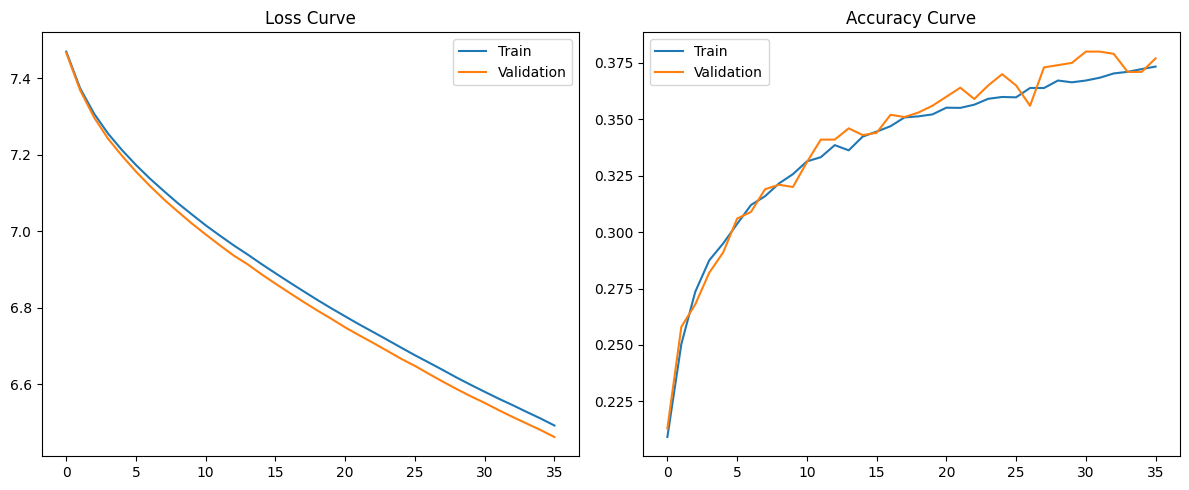

Validation accuracy: 0.3800

Best validation accuracy: 0.4780
Best hyperparameters: {'learning_rate': 0.1, 'hidden_size': 520, 'reg': 0.0001}
最佳超参数: {'learning_rate': 0.1, 'hidden_size': 520, 'reg': 0.0001}


In [6]:
best_params = hyperparameter_search(X_train, y_train, X_val, y_val)
print("最佳超参数:", best_params)

# ## 5. 使用最佳参数训练模型

# 根据超参数搜索找到的最佳参数

Training:   1%|          | 1/100 [00:12<20:36, 12.49s/it]

Epoch 0: train_loss=2.1742, val_acc=0.3030, lr=1.00e-02


Training:   6%|▌         | 6/100 [01:12<18:50, 12.03s/it]

Epoch 5: train_loss=1.9959, val_acc=0.3700, lr=1.00e-02


Training:  11%|█         | 11/100 [02:12<17:56, 12.09s/it]

Epoch 10: train_loss=1.9279, val_acc=0.3830, lr=9.50e-03


Training:  16%|█▌        | 16/100 [03:13<16:51, 12.04s/it]

Epoch 15: train_loss=1.8759, val_acc=0.3920, lr=9.50e-03


Training:  21%|██        | 21/100 [04:13<15:46, 11.99s/it]

Epoch 20: train_loss=1.8509, val_acc=0.4010, lr=9.03e-03


Training:  26%|██▌       | 26/100 [05:12<14:45, 11.97s/it]

Epoch 25: train_loss=1.8031, val_acc=0.4200, lr=9.03e-03


Training:  31%|███       | 31/100 [06:12<13:49, 12.02s/it]

Epoch 30: train_loss=1.7802, val_acc=0.4290, lr=8.57e-03


Training:  36%|███▌      | 36/100 [07:13<12:51, 12.05s/it]

Epoch 35: train_loss=1.7555, val_acc=0.4400, lr=8.57e-03


Training:  41%|████      | 41/100 [08:13<11:51, 12.06s/it]

Epoch 40: train_loss=1.7437, val_acc=0.4510, lr=8.15e-03


Training:  46%|████▌     | 46/100 [09:13<10:48, 12.00s/it]

Epoch 45: train_loss=1.7239, val_acc=0.4590, lr=8.15e-03


Training:  51%|█████     | 51/100 [10:13<09:50, 12.06s/it]

Epoch 50: train_loss=1.7059, val_acc=0.4560, lr=7.74e-03


Training:  56%|█████▌    | 56/100 [11:13<08:48, 12.01s/it]

Epoch 55: train_loss=1.7030, val_acc=0.4620, lr=7.74e-03


Training:  61%|██████    | 61/100 [12:13<07:48, 12.01s/it]

Epoch 60: train_loss=1.6944, val_acc=0.4660, lr=7.35e-03


Training:  66%|██████▌   | 66/100 [13:13<06:49, 12.03s/it]

Epoch 65: train_loss=1.6777, val_acc=0.4740, lr=7.35e-03


Training:  71%|███████   | 71/100 [14:13<05:48, 12.00s/it]

Epoch 70: train_loss=1.6607, val_acc=0.4760, lr=6.98e-03


Training:  76%|███████▌  | 76/100 [15:13<04:48, 12.02s/it]

Epoch 75: train_loss=1.6709, val_acc=0.4710, lr=6.98e-03


Training:  81%|████████  | 81/100 [16:14<03:48, 12.05s/it]

Epoch 80: train_loss=1.6664, val_acc=0.4800, lr=6.63e-03


Training:  86%|████████▌ | 86/100 [17:14<02:48, 12.02s/it]

Epoch 85: train_loss=1.6337, val_acc=0.4860, lr=6.63e-03


Training:  91%|█████████ | 91/100 [18:14<01:47, 12.00s/it]

Epoch 90: train_loss=1.6225, val_acc=0.4850, lr=6.30e-03


Training:  96%|█████████▌| 96/100 [19:14<00:47, 11.98s/it]

Epoch 95: train_loss=1.6157, val_acc=0.4910, lr=6.30e-03


Training: 100%|██████████| 100/100 [20:02<00:00, 12.02s/it]


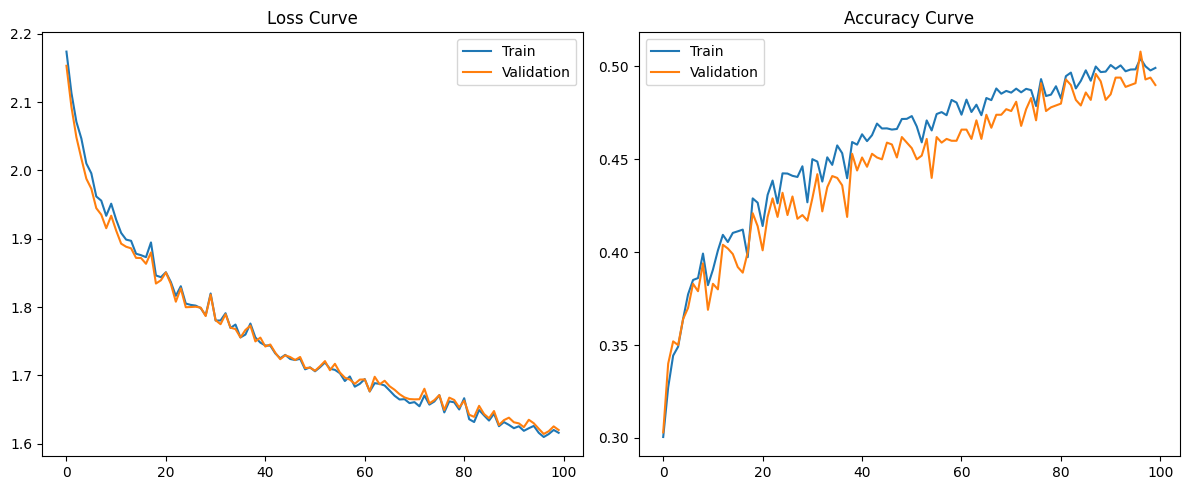

In [25]:
model = ThreeLayerNeuralNetwork(
    input_size=3072,
    hidden_size=200, # 使用预设的最佳隐藏层大小
    output_size=10,
    activation='relu'
)

# 训练模型 (所有计算在GPU上进行)
trained_model, history = train(
    model,
    X_train, y_train,
    X_val, y_val,
    learning_rate=1e-2,  # 使用预设的最佳学习率
    reg=1e-3,           # 使用预设的最佳正则化强度
    epochs=100,
    batch_size=256,
    early_stop=15
)


# ## 6. 测试评估 (GPU版本)


In [27]:
def test(model, X_test, y_test):
    scores = model.forward(X_test)  # 自动在GPU上计算
    pred = cp.argmax(scores, axis=1)
    accuracy = cp.mean(pred == y_test)
    print(f'Test accuracy: {float(accuracy):.4f}')  # 将结果转回CPU打印
    return float(accuracy)

# 在测试集上评估 (数据已在GPU上)
test_acc = test(trained_model, test_data, test_labels)

# 保存模型 (将参数转回CPU保存)
with open('best_model.pkl', 'wb') as f:
    cpu_params = {k: cp.asnumpy(v) for k, v in trained_model.params.items()}  # 转换到CPU
    pickle.dump({
        'params': cpu_params,
        'history': history,
        'test_acc': test_acc
    }, f)


Test accuracy: 0.5054


整体测试准确率: 0.5054

分类别准确率:
airplane: 0.5700
automobile: 0.6740
bird: 0.3840
cat: 0.3190
deer: 0.3860
dog: 0.3680
frog: 0.6430
horse: 0.5290
ship: 0.6550
truck: 0.5260


TypeError: Implicit conversion to a NumPy array is not allowed. Please use `.get()` to construct a NumPy array explicitly.

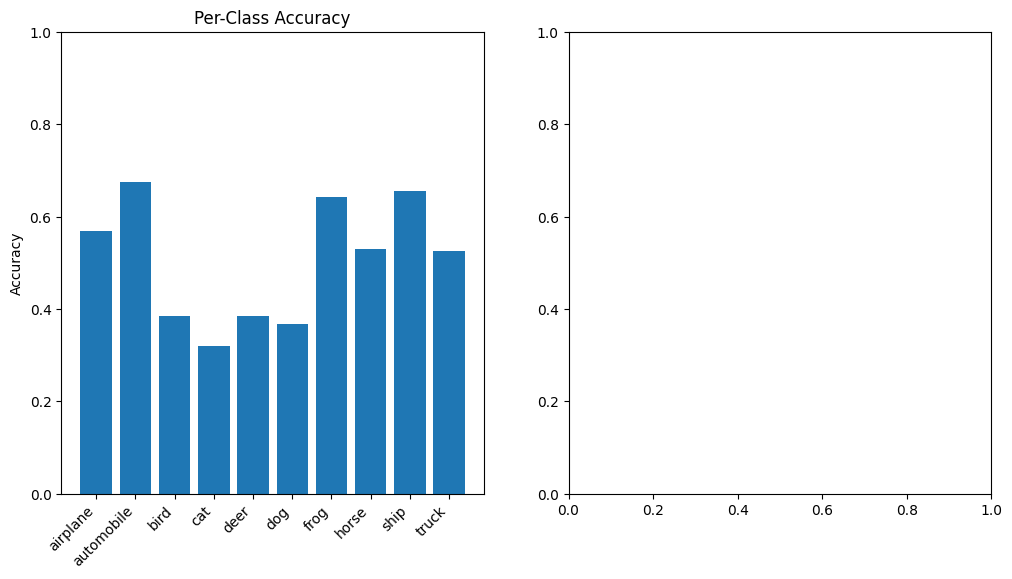

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import cupy as cp

def test(model, X_test, y_test, class_names=None, show_plot=True):
    """
    增强版测试函数，包含分类别准确率计算和可视化
    参数:
        class_names: 类别名称列表（如CIFAR-10的['airplane', 'automobile', ...]）
        show_plot: 是否显示可视化图表
    """
    """兼容原始标签和one-hot编码的测试函数"""
    # 前向计算
    scores = model.forward(X_test)
    pred = cp.argmax(scores, axis=1)
    
    # 自动处理标签格式
    if y_test.ndim == 2 and y_test.shape[1] > 1:  # one-hot编码
        y_true = cp.argmax(y_test, axis=1)
    else:  # 原始标签
        y_true = y_test.flatten().astype(int)  # 确保是整数类型
    
    # 计算整体准确率
    accuracy = cp.mean(pred == y_true)
    
    # 计算每个类别的准确率
    num_classes = len(class_names) if class_names else int(cp.max(y_true) + 1)
    class_acc = {}
    for i in range(num_classes):
        idx = cp.where(y_true == i)[0]
        if len(idx) == 0:
            class_acc[i] = 0.0
            continue
        correct = cp.sum(pred[idx] == y_true[idx])
        class_acc[i] = float(correct / len(idx))
    
    # 打印结果
    print(f'整体测试准确率: {float(accuracy):.4f}')
    print("\n分类别准确率:")
    for cls, acc in class_acc.items():
        cls_name = class_names[cls] if class_names else f'类别{cls}'
        print(f"{cls_name}: {acc:.4f}")
    
    # 可视化
    if show_plot:
        plt.figure(figsize=(12, 6))
        
        # 柱状图
        plt.subplot(1, 2, 1)
        if class_names:
            x_labels = class_names
        else:
            x_labels = [f'Class {i}' for i in range(num_classes)]
        plt.bar(x_labels, list(class_acc.values()))
        plt.title('Per-Class Accuracy')
        plt.xticks(rotation=45, ha='right')
        plt.ylim(0, 1)
        plt.ylabel('Accuracy')
        
        # 混淆矩阵（示例）
        plt.subplot(1, 2, 2)
        cm = cp.zeros((num_classes, num_classes), dtype=int)
        for t, p in zip(y_true.get(), pred.get()):  # 转换为numpy
            cm[t, p] += 1
        sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
                   xticklabels=x_labels, yticklabels=x_labels)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        
        plt.tight_layout()
        
        # 保存图片
        plt.savefig('class_acc_visualization.png', bbox_inches='tight')
        plt.show()
    
    return float(accuracy), class_acc

# 使用示例（假设使用CIFAR-10）
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# 在测试集上评估并可视化
test_acc, class_acc = test(trained_model, test_data, test_labels, 
                          class_names=class_names)

# 保存模型（添加可视化信息）
with open('best_model.pkl', 'wb') as f:
    cpu_params = {k: cp.asnumpy(v) for k, v in trained_model.params.items()}
    pickle.dump({
        'params': cpu_params,
        'history': history,
        'test_acc': test_acc,
        'class_acc': class_acc,  # 新增分类别准确率
        'visualization': 'class_acc_visualization.png'  # 图表路径
    }, f)

/tmp/ipykernel_31/558657708.py:101: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  plt.savefig('network_parameters.png',


可视化完成，结果已保存为 network_parameters.png


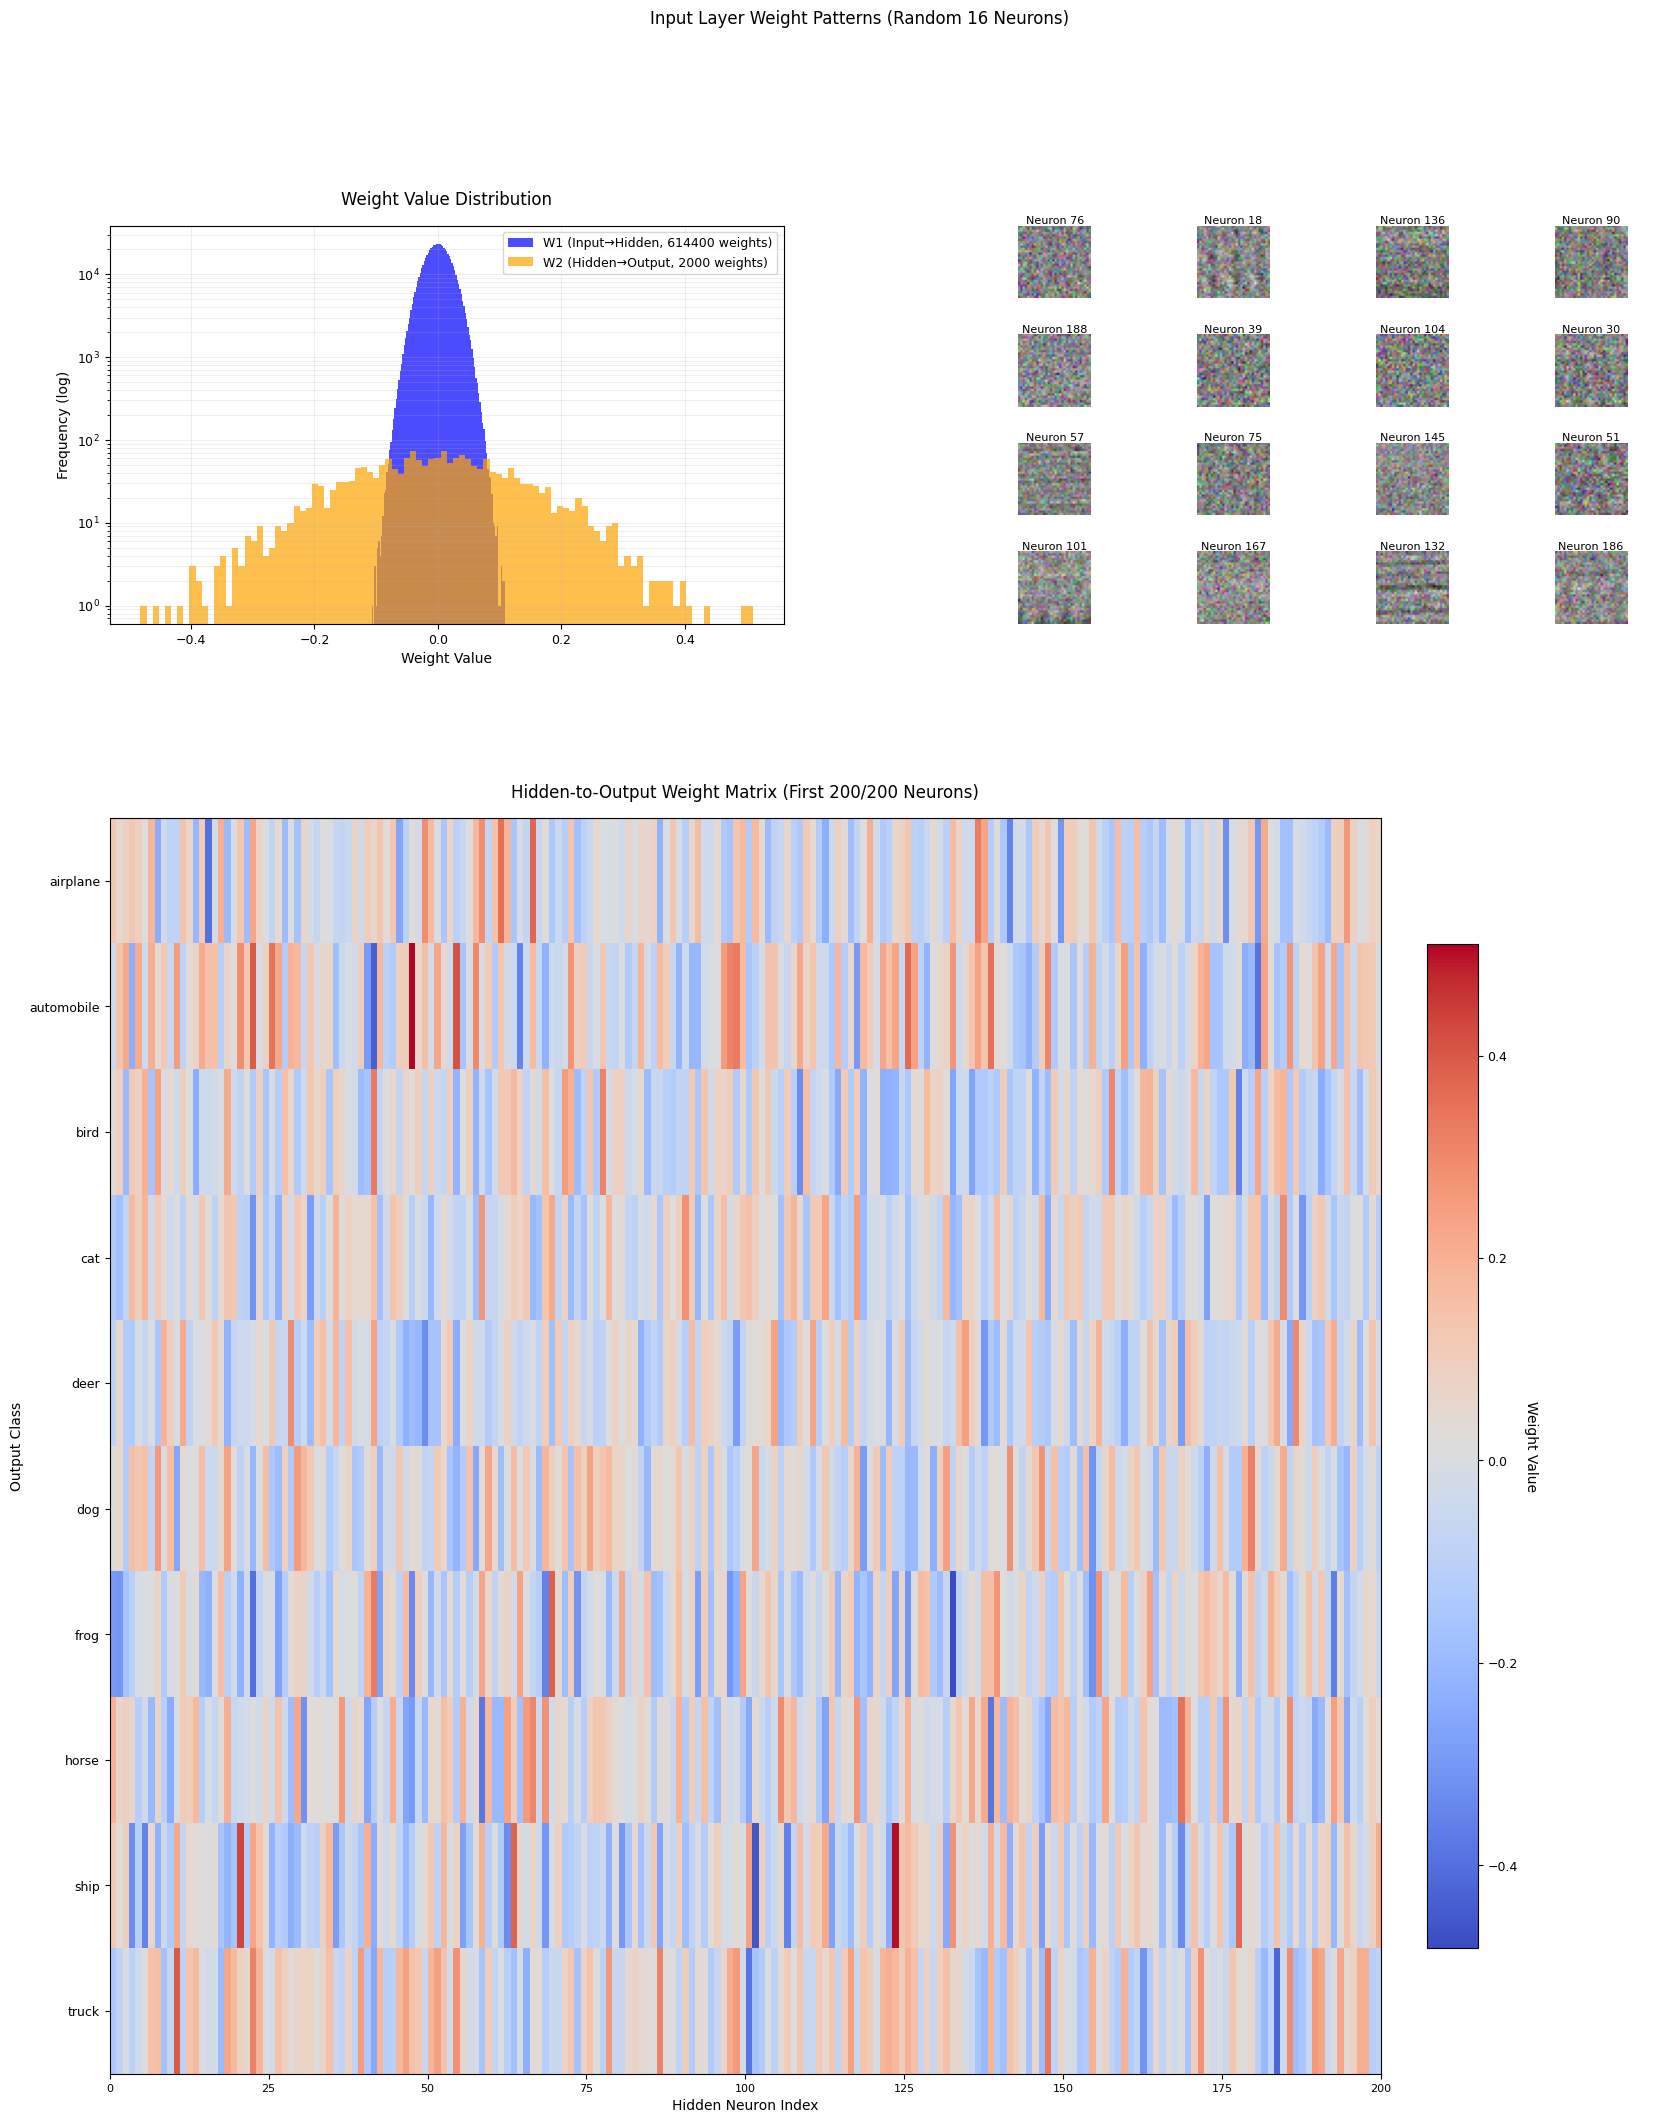

In [28]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


def visualize_network_parameters(model_path):
    """可视化神经网络参数"""
    # 加载模型
    
    with open(model_path, 'rb') as f:
        model_data = pickle.load(f)
        params = model_data['params']

    # 获取参数
    W1 = params['W1']  # (3072, hidden_size)
    W2 = params['W2']  # (hidden_size, 10)
    hidden_size = W1.shape[1]

    

    # 创建主画布（增大图形尺寸并调整DPI）
    fig = plt.figure(figsize=(20, 24), dpi=100, layout='constrained')
    gs = GridSpec(3, 2, figure=fig,
                  height_ratios=[1.2, 1.2, 2],  # 增加高度比例
                  width_ratios=[1, 1],
                  hspace=0.4, wspace=0.3)  # 增加子图间距

    # --------------------------
    # 权重分布直方图
    # --------------------------
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.hist(W1.flatten(), bins=100, alpha=0.7,
             label=f'W1 (Input→Hidden, {W1.size} weights)',
             color='blue')
    ax1.hist(W2.flatten(), bins=100, alpha=0.7,
             label=f'W2 (Hidden→Output, {W2.size} weights)',
             color='orange')
    ax1.set_title('Weight Value Distribution', pad=15, fontsize=12)
    ax1.set_xlabel('Weight Value', fontsize=10)
    ax1.set_ylabel('Frequency (log)', fontsize=10)
    ax1.set_yscale('log')
    ax1.legend(fontsize=9)
    ax1.grid(True, which="both", ls="-", alpha=0.2)
    ax1.tick_params(axis='both', which='major', labelsize=9)

    # --------------------------
    # 输入层权重可视化 (展示部分)
    # --------------------------
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.axis('off')

    # 创建更宽松的内部网格
    inner_gs = gs[0, 1].subgridspec(4, 4, wspace=0.3, hspace=0.5)

    # 随机选择16个隐藏神经元
    sample_neurons = np.random.choice(hidden_size, 16, replace=False)
    sample_weights = W1[:, sample_neurons].reshape(32, 32, 3, 16).transpose(3, 0, 1, 2)

    for i in range(16):
        ax = fig.add_subplot(inner_gs[i])
        neuron_weights = sample_weights[i]
        neuron_weights = (neuron_weights - neuron_weights.min()) / (neuron_weights.max() - neuron_weights.min() + 1e-8)
        ax.imshow(neuron_weights)
        ax.set_title(f'Neuron {sample_neurons[i]}', fontsize=8, pad=1)
        ax.axis('off')

    fig.suptitle('Input Layer Weight Patterns (Random 16 Neurons)',
                 y=0.97, fontsize=12)

    # --------------------------
    # 输出层权重热力图
    # --------------------------
    ax3 = fig.add_subplot(gs[1:, :])
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

    # 动态调整显示神经元数量
    display_neurons = min(500, hidden_size)  # 最多显示300个神经元
    heatmap_data = W2.T[:, :display_neurons]

    im = ax3.imshow(heatmap_data, cmap='coolwarm', aspect='auto',
                    extent=[0, display_neurons, 9.5, -0.5],
                    interpolation='nearest')

    ax3.set_title(f'Hidden-to-Output Weight Matrix (First {display_neurons}/{hidden_size} Neurons)',
                  pad=15, fontsize=12)
    ax3.set_xlabel('Hidden Neuron Index', fontsize=10)
    ax3.set_ylabel('Output Class', fontsize=10)
    ax3.set_yticks(np.arange(10))
    ax3.set_yticklabels(class_names, fontsize=9)
    ax3.tick_params(axis='x', labelsize=8)
    ax3.grid(False)

    # 添加颜色条（调整位置和大小）
    cbar = fig.colorbar(im, ax=ax3, pad=0.03, shrink=0.8)
    cbar.ax.tick_params(labelsize=9)
    cbar.set_label('Weight Value', rotation=270, labelpad=15, fontsize=10)

    # 保存图形（调整边界）
    plt.savefig('network_parameters.png',
                bbox_inches='tight',
                pad_inches=0.5,  # 增加内边距
                dpi=150)  # 适当降低DPI以减小文件大小
    #plt.close()  # 显式关闭图形释放内存


if __name__ == "__main__":
    visualize_network_parameters('best_model.pkl')
    print("可视化完成，结果已保存为 network_parameters.png")